# **Importing Required Packages**

In [1]:
# STEP 0: Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam


# **Connecting to the Drive And Unzipping DataSet**

In [2]:
# STEP 1: Mount Google Drive & Unzip Dataset
from google.colab import drive
drive.mount('/content/drive')

#Replace filename if your ZIP name is different
!unzip -q "/content/drive/My Drive/Dataset_pds_deepfake.zip" -d /content/


Mounted at /content/drive


# **Dataset Description**

In [7]:
import os
import cv2

# Check one sample image
sample_image_path = "/content/Train/Real/real_1.jpg"
image = cv2.imread(sample_image_path)
print("Image shape (H, W, C):", image.shape)
print("Height:", image.shape[0])
print("Width:", image.shape[1])
print("Channels:", image.shape[2])

# Dataset overview
BASE_DIR = "/content/"
splits = ["Train", "Validation", "Test"]
classes = ["Real", "Fake"]

total_images = 0
total_size = 0
image_types = set()
image_shapes = set()

for split in splits:
    print(f"{split} Set:")
    for cls in classes:
        folder = os.path.join(BASE_DIR, split, cls)
        images = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        num_images = len(images)
        total_images += num_images
        max_size = max(os.path.getsize(os.path.join(folder, f)) for f in images) if images else 0
        total_size += sum(os.path.getsize(os.path.join(folder, f)) for f in images)
        if images:
            img = cv2.imread(os.path.join(folder, images[0]))
            if img is not None:
                image_shapes.add(img.shape)
        image_types.update(os.path.splitext(f)[1] for f in images)
        print(f"  {cls}: {num_images} images | Max size: {max_size / (1024 * 1024):.2f} MB")

# Summary
print("\nTotal Images:", total_images)
print("Total Dataset Size (MB):", round(total_size / (1024 * 1024), 2))
print("Image Types:", ', '.join(image_types))
print("Example Shapes:", image_shapes)


Image shape (H, W, C): (256, 256, 3)
Height: 256
Width: 256
Channels: 3
Train Set:
  Real: 70001 images | Max size: 0.02 MB
  Fake: 70001 images | Max size: 0.02 MB
Validation Set:
  Real: 19787 images | Max size: 0.02 MB
  Fake: 19641 images | Max size: 0.03 MB
Test Set:
  Real: 5413 images | Max size: 0.03 MB
  Fake: 5492 images | Max size: 0.03 MB

Total Images: 190335
Total Dataset Size (MB): 1719.42
Image Types: .jpg
Example Shapes: {(256, 256, 3)}


In [ ]:
# STEP 2: Set dataset paths (use correct folder names)
BASE_DIR = '/content/'
TRAIN_DIR = os.path.join(BASE_DIR, 'Train')
VAL_DIR = os.path.join(BASE_DIR, 'Validation')
TEST_DIR = os.path.join(BASE_DIR, 'Test')


# STEP 3: Parameters
IMAGE_SIZE = (160, 160) # 98
BATCH_SIZE = 32         # 64, 128
EPOCHS = 5

# **Data Preprocessing**

In [ ]:
# STEP 4: Data Generators
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_gen = datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_gen = datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("✅ Class Mapping:", train_gen.class_indices)

Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.
✅ Class Mapping: {'Fake': 0, 'Real': 1}


# **Model Architecture**

In [ ]:

# STEP 5: Build the Model (MobileNetV2 + custom classifier)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])


# **Model Training**

In [ ]:
# STEP 6: Train the Model
history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS)

Epoch 1/5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 3433s 782ms/step - accuracy: 0.7291 - loss: 0.5271 - val_accuracy: 0.7732 - val_loss: 0.4697
Epoch 2/5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 3301s 754ms/step - accuracy: 0.7790 - loss: 0.4580 - val_accuracy: 0.7774 - val_loss: 0.4616
Epoch 3/5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 3258s 745ms/step - accuracy: 0.7817 - loss: 0.4488 - val_accuracy: 0.7873 - val_loss: 0.4468
Epoch 4/5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 3301s 754ms/step - accuracy: 0.7873 - loss: 0.4388 - val_accuracy: 0.7934 - val_loss: 0.4358
Epoch 5/5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 3257s 744ms/step - accuracy: 0.7922 - loss: 0.4315 - val_accuracy: 0.7951 - val_loss: 0.4327


# **Evaluation Metrics**

341/341 ━━━━━━━━━━━━━━━━━━━━ 210s 608ms/step

📊 Classification Report:

              precision    recall  f1-score   support

        Fake       0.71      0.76      0.73      5492
        Real       0.74      0.68      0.71      5413

    accuracy                           0.72     10905
   macro avg       0.72      0.72      0.72     10905
weighted avg       0.72      0.72      0.72     10905



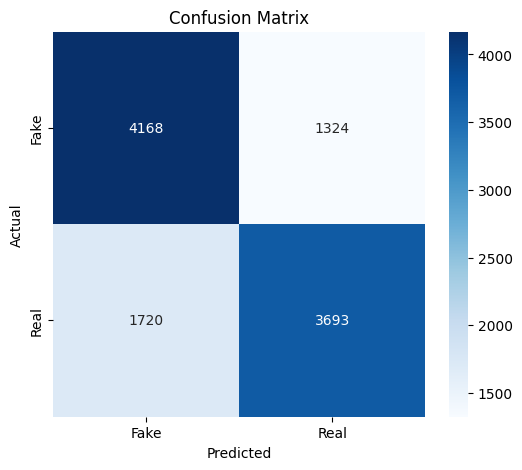

In [ ]:
# STEP 7: Evaluate on Test Set
test_gen.reset()
probs = model.predict(test_gen)
preds = (probs > 0.5).astype(int)
y_true = test_gen.classes

print("\n Classification Report:\n")
print(classification_report(y_true, preds, target_names=["Fake", "Real"]))

# Confusion Matrix
cm = confusion_matrix(y_true, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# **Visualizing Feature Maps**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


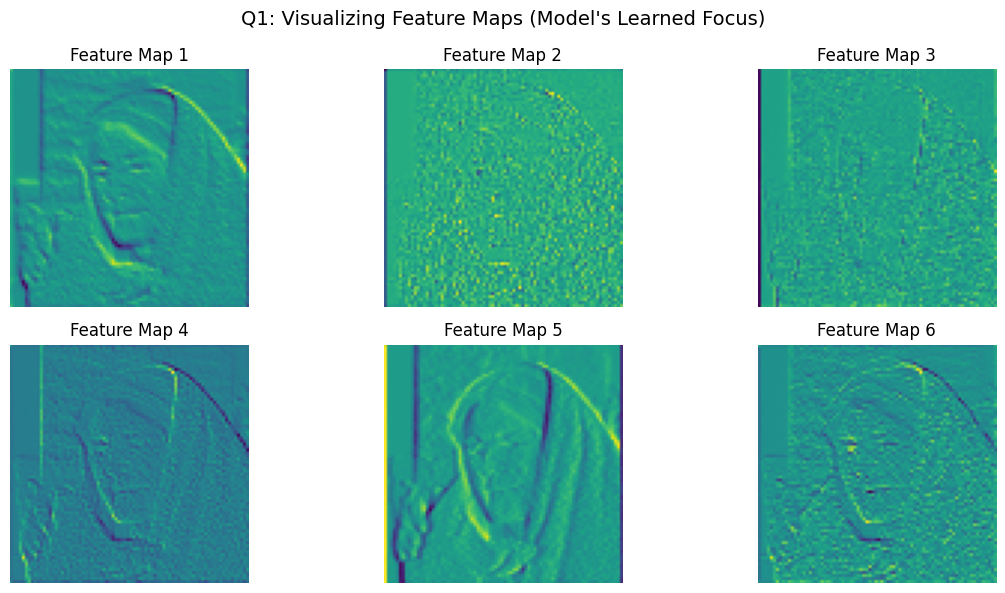

In [ ]:
from tensorflow.keras.models import Model


layer_name = 'block_1_expand'
feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)

img_path = test_gen.filepaths[0]
img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMAGE_SIZE)
img_array = tf.keras.preprocessing.image.img_to_array(img)[None, ...] / 255.0


features = feature_extractor.predict(img_array)[0]


plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(features[:, :, i], cmap='viridis')
    plt.title(f"Feature Map {i+1}")
    plt.axis('off')
plt.suptitle(" Visualizing Feature Maps (Model's Learned Focus)", fontsize=14)
plt.tight_layout()
plt.show()


# **Histogram**

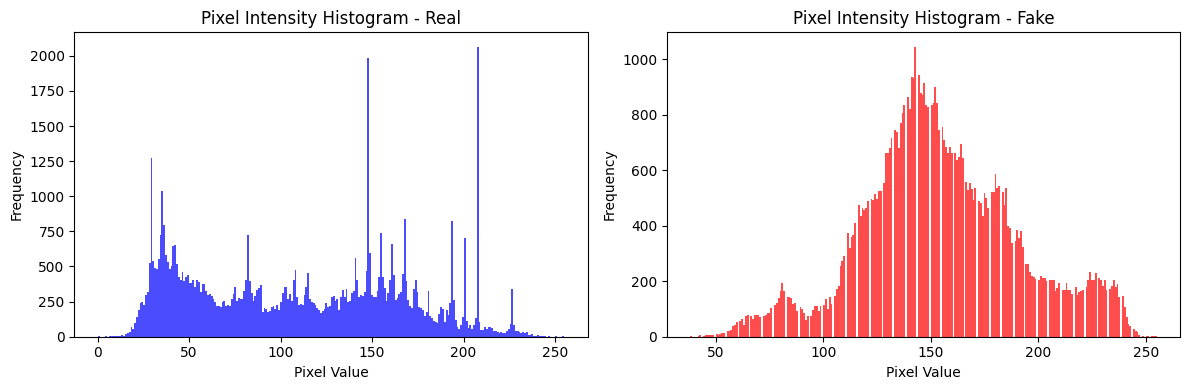

In [ ]:

img_real = cv2.imread('/content/DeepFakeDataset/Test/Real/real_001.jpg', cv2.IMREAD_GRAYSCALE)
img_fake = cv2.imread('/content/DeepFakeDataset/Test/Fake/fake_001.jpg', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(img_real.ravel(), bins=256, color='blue', alpha=0.7)
plt.title("Pixel Intensity Histogram - Real")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(img_fake.ravel(), bins=256, color='red', alpha=0.7)
plt.title("Pixel Intensity Histogram - Fake")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


## **Line Plot**

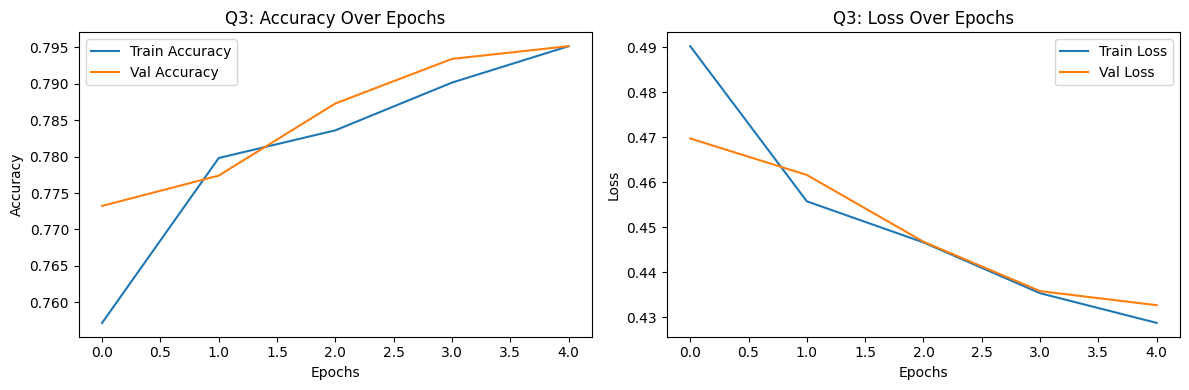

In [ ]:

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Q3: Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Q3: Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()